In [1]:
import torch
import torchvision

In [2]:
# !cd images

In [3]:
data_dir = './images/'
#load image folder
train_images=torchvision.datasets.ImageFolder(root=data_dir+'train',transform=torchvision.transforms.ToTensor())
valida_images=torchvision.datasets.ImageFolder(root=data_dir+'validation',transform=torchvision.transforms.ToTensor())
train_dataset=torch.utils.data.DataLoader(train_images,batch_size=256,shuffle=True)
valida_dataset=torch.utils.data.DataLoader(valida_images,batch_size=256,shuffle=True)

In [4]:
#move to gpu
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#basic cnn model
#input is 48x48x3
#output is 8
#conv-32x3-relu-maxpool-conv-32x3-relu-maxpool-fc-1024-relu-fc-1024-relu-fc-8
classes=train_images.classes

In [5]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1=torch.nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.relu1=torch.nn.ReLU()
        self.maxpool1=torch.nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2=torch.nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.relu2=torch.nn.ReLU()
        self.maxpool2=torch.nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1=torch.nn.Linear(in_features=32*12*12,out_features=1024)
        self.relu3=torch.nn.ReLU()
        self.fc2=torch.nn.Linear(in_features=1024,out_features=1024)
        self.relu4=torch.nn.ReLU()
        self.fc3=torch.nn.Linear(in_features=1024,out_features=len(classes))
        self.softmax=torch.nn.Softmax(dim=1)
    def forward(self,x):
        x=self.conv1(x)
        x=self.relu1(x)
        x=self.maxpool1(x)
        x=self.conv2(x)
        x=self.relu2(x)
        x=self.maxpool2(x)

        x=x.view(-1,32*12*12)
        x=self.fc1(x)
        x=self.relu3(x)
        x=self.fc2(x)
        x=self.relu4(x)
        x=self.fc3(x)
        return self.softmax(x)

    

In [6]:
model=CNN().to(device)
#train model
#loss function
criterion=torch.nn.CrossEntropyLoss()
#optimizer
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
epochs=10
for epoch in range(epochs):
    for i,(images,labels) in enumerate(train_dataset):
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=model(images)
        loss=criterion(outputs,labels)
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1)%100==0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1,epochs,i+1,len(train_dataset),loss.item()))
        if epoch==10:
            #print training accuracy
            correct=0
            total=0
            with torch.no_grad():
                for images,labels in train_dataset:
                    images=images.to(device)
                    labels=labels.to(device)
                    outputs=model(images)
                    _,predicted=torch.max(outputs.data,1)
                    total+=labels.size(0)
                    correct+=(predicted==labels).sum().item()
            print('Accuracy of the network on the train images: {} %'.format(100*correct/total))

Epoch [1/10], Step [100/113], Loss: 1.8559
Epoch [2/10], Step [100/113], Loss: 1.8522
Epoch [3/10], Step [100/113], Loss: 1.7650
Epoch [4/10], Step [100/113], Loss: 1.7144
Epoch [5/10], Step [100/113], Loss: 1.6336
Epoch [6/10], Step [100/113], Loss: 1.7102
Epoch [7/10], Step [100/113], Loss: 1.7100
Epoch [8/10], Step [100/113], Loss: 1.6105
Epoch [9/10], Step [100/113], Loss: 1.6534
Epoch [10/10], Step [100/113], Loss: 1.6207


In [7]:
#check accuracy
correct=0
total=0
with torch.no_grad():
    for images,labels in valida_dataset:
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
print('Accuracy of the network on the 10000 test images: {} %'.format(100*correct/total))
correct=0
total=0
with torch.no_grad():
    for images,labels in train_dataset:
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    print('Accuracy of the network on the train images: {} %'.format(100*correct/total))

Accuracy of the network on the 10000 test images: 48.49985847721483 %
Accuracy of the network on the train images: 57.22216439401825 %


In [8]:
import torchvision.models as models
#efficicentnet v2
model=models.efficientnet_b0(pretrained=True)
#change output to 7
model.classifier[1]=torch.nn.Linear(in_features=1280,out_features=len(classes))
model.to(device)

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [9]:
%%time
#train model
#loss function
criterion=torch.nn.CrossEntropyLoss()
#optimizer
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
epochs=10
for epoch in range(epochs):
    for i,(images,labels) in enumerate(train_dataset):
        images=images.to(device)
        labels=labels.to(device)
        #forward pass
        outputs=model(images)
        loss=criterion(outputs,labels)
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i%100==0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1,epochs,i+1,len(train_dataset),loss.item()))
        if epoch==10:
            #print training accuracy
            correct=0
            total=0
            with torch.no_grad():
                for images,labels in train_dataset:
                    images=images.to(device)
                    labels=labels.to(device)
                    outputs=model(images)
                    _,predicted=torch.max(outputs.data,1)
                    total+=labels.size(0)
                    correct+=(predicted==labels).sum().item()
            print('Accuracy of the network on the train images: {} %'.format(100*correct/total))

Epoch [1/10], Step [1/113], Loss: 2.0526
Epoch [1/10], Step [101/113], Loss: 1.3620
Epoch [2/10], Step [1/113], Loss: 1.1408
Epoch [2/10], Step [101/113], Loss: 1.0595
Epoch [3/10], Step [1/113], Loss: 0.9330
Epoch [3/10], Step [101/113], Loss: 0.9774
Epoch [4/10], Step [1/113], Loss: 0.7723
Epoch [4/10], Step [101/113], Loss: 0.8757
Epoch [5/10], Step [1/113], Loss: 0.6787
Epoch [5/10], Step [101/113], Loss: 0.7993
Epoch [6/10], Step [1/113], Loss: 0.5163
Epoch [6/10], Step [101/113], Loss: 0.6607
Epoch [7/10], Step [1/113], Loss: 0.4796
Epoch [7/10], Step [101/113], Loss: 0.3976
Epoch [8/10], Step [1/113], Loss: 0.3854
Epoch [8/10], Step [101/113], Loss: 0.4332
Epoch [9/10], Step [1/113], Loss: 0.2690
Epoch [9/10], Step [101/113], Loss: 0.4309
Epoch [10/10], Step [1/113], Loss: 0.2118
Epoch [10/10], Step [101/113], Loss: 0.3239
CPU times: user 2min 52s, sys: 5.03 s, total: 2min 57s
Wall time: 2min 57s


In [10]:
#check accuracy
correct=0
total=0
with torch.no_grad():
    for images,labels in valida_dataset:
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
print('Accuracy of the network on the 10000 test images: {} %'.format(100*correct/total))
correct=0
total=0
with torch.no_grad():
    for images,labels in train_dataset:
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    print('Accuracy of the network on the train images: {} %'.format(100*correct/total))

Accuracy of the network on the 10000 test images: 61.279365977922446 %
Accuracy of the network on the train images: 94.07723534922452 %


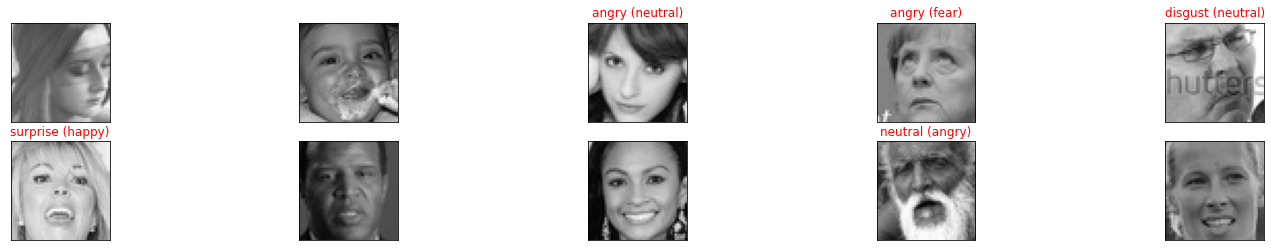

In [11]:
#plot some images
import matplotlib.pyplot as plt
import numpy as np
#get some random validation images
dataiter=iter(valida_dataset)
images,labels=dataiter.next()
images=images.to(device)
labels=labels.to(device)
#get predictions
outputs=model(images)
_,predicted=torch.max(outputs,1)
#plot the 10 images
fig=plt.figure(figsize=(25,4))
for i in range(10):
    ax=fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    img=np.squeeze(images.cpu().numpy()[i])
    img = img.swapaxes(0,1)
    img = img.swapaxes(1,2)
    ax.imshow(img)
    ax.set_title("{} ({})".format(classes[labels[i].item()],classes[predicted[i].item()]),color="white" if labels[i].item()==predicted[i].item() else "red")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [12]:
torch.save(model.state_dict(), "./effnet_model.pth")
